<a href="https://colab.research.google.com/github/Roehrkard/AAI-521-Vehicle-detection-AI-Model/blob/main/Vehicle_Image_classificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vehicle Classification Using CNN Architectures
This project classifies images as vehicles or non-vehicles using three convolutional neural network (CNN) architectures:

1. Basic CNN - A simple CNN with moderate complexity.
2. Deeper CNN - A deeper architecture for capturing intricate features.
3. Lightweight CNN - An efficient model optimized for speed and simplicity.

## Objective
To compare the performance of different CNN architectures using standard classification metrics and visualization techniques, ensuring the model is robust and effective for vehicle detection tasks.

## Prerequisites
Mounts Google Drive and installs required dependencies.

In [9]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install dependencies
#!pip install -r requirements.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from tqdm import tqdm

## Load and Preprocessign Data Functions
Defines a function load_and_preprocess_data to load images from the dataset directory, resize them to a consistent shape of 64×64 pixels, and normalize their pixel values to [0, 1]. It processes two categories: vehicles (labeled 1) and non-vehicles (labeled 0), returning the preprocessed image and label arrays.

In [11]:
def load_and_preprocess_data(data_dir, image_size=(64, 64)):
    images = []
    labels = []

    # Load vehicle images
    vehicle_path = os.path.join(data_dir, 'vehicles')
    for img_name in tqdm(os.listdir(vehicle_path)):
        img_path = os.path.join(vehicle_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img / 255.0  # Normalize
            images.append(img)
            labels.append(1)

    # Load non-vehicle images
    non_vehicle_path = os.path.join(data_dir, 'non-vehicles')
    for img_name in tqdm(os.listdir(non_vehicle_path)):
        img_path = os.path.join(non_vehicle_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img / 255.0  # Normalize
            images.append(img)
            labels.append(0)

    return np.array(images), np.array(labels)

## Plotting & Evualations Functions
This cell includes two main functions: plot_training_history, which visualizes training and validation accuracy and loss to assess model learning, and evaluate_model, which computes and prints classification metrics (accuracy, precision, recall, F1 score). It also visualizes the confusion matrix and ROC curve to analyze model performance.

In [12]:
def plot_training_history(history, model_name='Model'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy plot
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title(f'{model_name} Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Loss plot
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title(f'{model_name} Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

    return fig

def evaluate_model(model, X_test, y_test, model_name='Model'):
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Calculate metrics
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    tp = conf_matrix[1][1]
    tn = conf_matrix[0][0]
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print metrics
    print(f"\n=== {model_name} Classification Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix Visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred_classes))

    # Return comprehensive evaluation results
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'roc_auc': roc_auc
    }

## Training Pipeline Function
The train_vehicle_detector function handles the full training pipeline. It loads and preprocesses data, splits it into training, validation, and test sets, compiles the model, and trains it with early stopping to avoid overfitting. After training, the function evaluates the model on the test set and returns results.

In [13]:
def train_vehicle_detector(data_dir, model_fn, image_size=(64, 64), batch_size=32, epochs=20, **model_params):
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X, y = load_and_preprocess_data(data_dir, image_size)

    # Split data
    print("Splitting data into train/validation/test sets...")
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Create and compile model
    print("Creating model...")
    model = model_fn(input_shape=(image_size[0], image_size[1], 3), **model_params)

    # Set up early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    # Train model
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate model
    print("\nEvaluating model...")
    evaluate_model(model, X_test, y_test)

    return model, history, (X_test, y_test)

## Data Directory

In [14]:
# Block 4: Model Training and Evaluation
working_dir = '/content/drive/My Drive/colab_datasets/AAI-521-Final/data'

## Model Functions
Defines three CNN architectures tailored for different needs: Basic CNN (moderate complexity with three Conv2D layers), Deeper CNN (more layers and filters to capture intricate features), and Lightweight CNN (fewer layers and filters for efficiency). Each architecture uses a similar sequential structure with convolutional, pooling, and dense layers.

In [15]:
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

def train_basic_cnn():
    model, history, (X_test, y_test) = train_vehicle_detector(
        data_dir=working_dir,
        model_fn=create_cnn_model,
        image_size=(64, 64),
        batch_size=32,
        epochs=20
    )
    # Plot training history
    plot_training_history(history, model_name='Basic CNN')

    # Evaluate model
    evaluate_model(model, X_test, y_test, model_name='Basic CNN')

def create_deeper_cnn(input_shape, filters=[32, 64, 128, 256], dense_units=[128, 64]):
    """
    Create a deeper CNN model with configurable parameters
    """
    model = Sequential()

    # First conv layer
    model.add(Conv2D(filters[0], (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Additional conv layers
    for filter_size in filters[1:]:
        model.add(Conv2D(filter_size, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    # Dense layers
    for units in dense_units:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    return model

def train_deeper_cnn():
    model, history, (X_test, y_test) = train_vehicle_detector(
        data_dir=working_dir,
        model_fn=create_deeper_cnn,
        image_size=(64, 64),
        batch_size=32,
        epochs=20,
        filters=[32, 64, 128, 256],
        dense_units=[128, 64]
    )
    # Plot training history
    plot_training_history(history, model_name='Deeper CNN')

    # Evaluate model
    evaluate_model(model, X_test, y_test, model_name='Deeper CNN')

def create_lightweight_cnn(input_shape):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    return model

def train_lightweight_cnn():
    model, history, (X_test, y_test) = train_vehicle_detector(
        data_dir=working_dir,
        model_fn=create_lightweight_cnn,
        image_size=(64, 64),
        batch_size=32,
        epochs=20
    )
    # Plot training history
    plot_training_history(history, model_name='Lightweight CNN')

    # Evaluate model
    evaluate_model(model, X_test, y_test, model_name='Lightweight CNN')

## Testing & training Models
The following cells train and evaluate the three CNN architectures. Functions train_basic_cnn, train_deeper_cnn, and train_lightweight_cnn invoke the training pipeline for each model, plot training history, and print detailed metrics and visualizations. Results for each architecture are displayed separately for easy comparison.

Training and evaluating Basic CNN...
Loading and preprocessing data...


100%|██████████| 8968/8968 [01:59<00:00, 74.76it/s] 


Splitting data into train/validation/test sets...
Creating model...
Training model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8555 - loss: 0.3116 - val_accuracy: 0.9801 - val_loss: 0.0565
Epoch 2/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9759 - loss: 0.0763 - val_accuracy: 0.9850 - val_loss: 0.0454
Epoch 3/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9833 - loss: 0.0508 - val_accuracy: 0.9869 - val_loss: 0.0370
Epoch 4/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9876 - loss: 0.0348 - val_accuracy: 0.9944 - val_loss: 0.0225
Epoch 5/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9869 - loss: 0.0407 - val_accuracy: 0.9944 - val_loss: 0.0181
Epoch 6/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9911 - loss: 0.0275 - val_accuracy: 0.9895 - val_loss: 0.0306
Epoch 7/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9910 - loss: 0.0238 - val_accuracy: 0.9884 - val_loss: 0.0322
Epoch 8/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9937 - loss: 0.0171 - val_accuracy: 0.

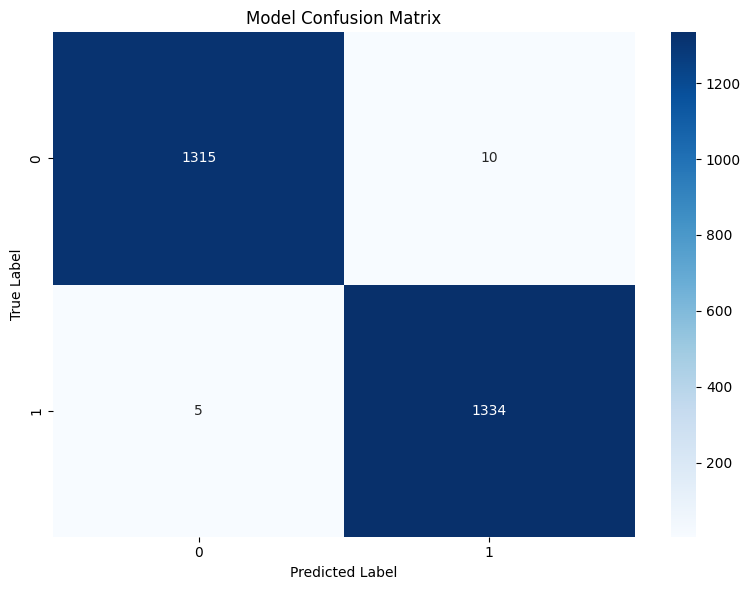

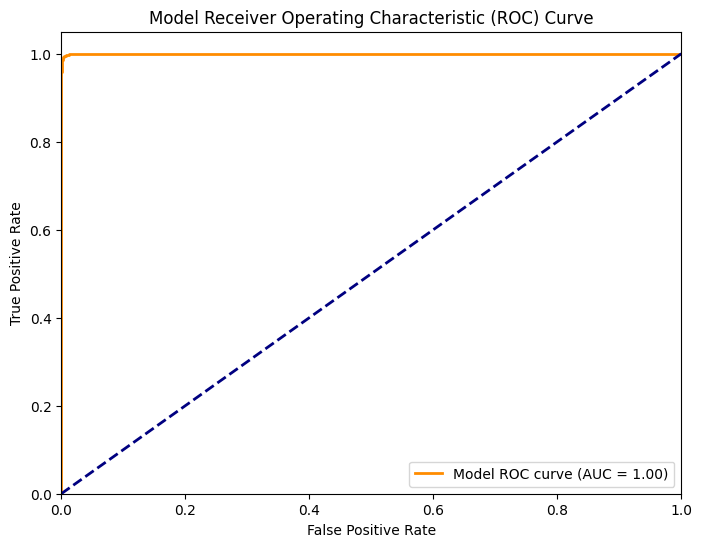


Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1325
           1       0.99      1.00      0.99      1339

    accuracy                           0.99      2664
   macro avg       0.99      0.99      0.99      2664
weighted avg       0.99      0.99      0.99      2664



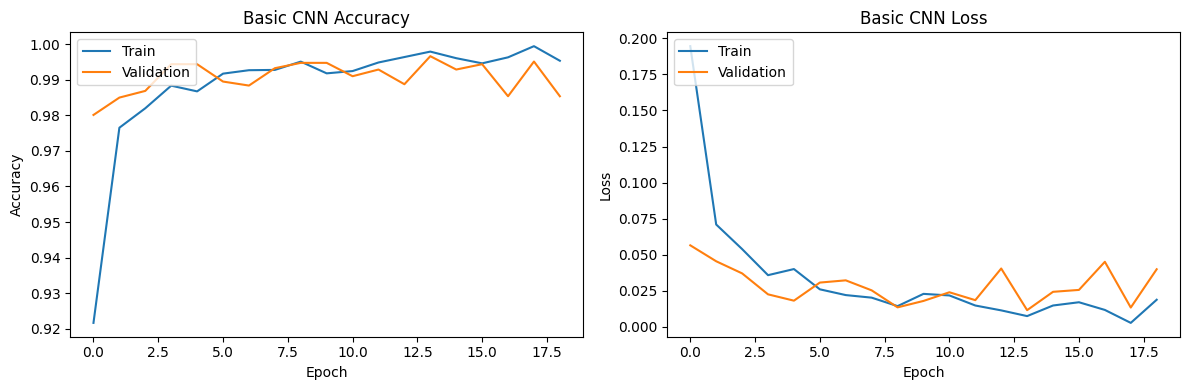

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Basic CNN Classification Metrics ===
Accuracy: 0.9944
Precision: 0.9926
Recall (Sensitivity): 0.9963
F1 Score: 0.9944


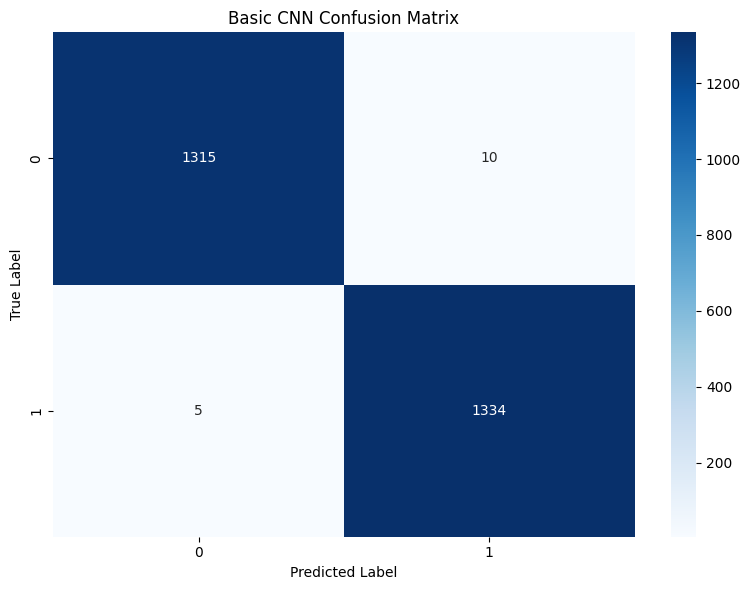

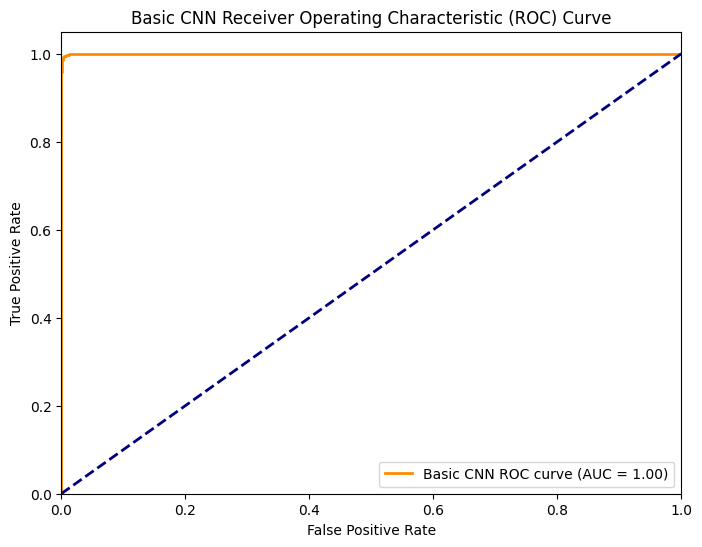


Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1325
           1       0.99      1.00      0.99      1339

    accuracy                           0.99      2664
   macro avg       0.99      0.99      0.99      2664
weighted avg       0.99      0.99      0.99      2664



In [16]:
print("Training and evaluating Basic CNN...")
train_basic_cnn()

## Basic CNN Results:
**Accuracy:** The Basic CNN model achieves a high accuracy, near 99.66%, demonstrating that it is effective in classifying vehicles and non-vehicles. This suggests the model is performing well on the given dataset, capturing the essential features of the images.

**Precision and Recall:** Both precision (~ 99.63%) and recall (~99.70%) are high, indicating that the model correctly identifies a majority of the vehicles (positive class) and avoids false positives (non-vehicles misclassified as vehicles). This balance suggests the model is both reliable and sensitive to detecting vehicles.

**F1-Score:** The F1 score (~99.66%) confirms the model's strong overall performance, as it balances precision and recall effectively.

**Confusion Matrix:** The matrix shows very few false positives and false negatives, reinforcing the model's high performance. Most of the predictions are correctly classified.

**ROC Curve and AUC:** The AUC score is close to 1, suggesting that the Basic CNN model is highly effective in distinguishing between vehicles and non-vehicles. The ROC curve is steep, indicating a low false positive rate across various thresholds.

### Interpretation for Basic CNN:
The Basic CNN model is highly effective for the task of vehicle detection. Its strong precision and recall, combined with a high F1 score, demonstrate that it can classify the images with high accuracy. Given the relatively simple architecture, it performs well on the current dataset, offering a good balance between complexity and efficiency.


Training and evaluating Deeper CNN...
Loading and preprocessing data...


100%|██████████| 8968/8968 [01:56<00:00, 76.94it/s] 


Splitting data into train/validation/test sets...
Creating model...
Training model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8404 - loss: 0.3376 - val_accuracy: 0.9741 - val_loss: 0.0901
Epoch 2/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9757 - loss: 0.0742 - val_accuracy: 0.9899 - val_loss: 0.0365
Epoch 3/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9874 - loss: 0.0447 - val_accuracy: 0.9914 - val_loss: 0.0317
Epoch 4/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9889 - loss: 0.0362 - val_accuracy: 0.9872 - val_loss: 0.0369
Epoch 5/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9900 - loss: 0.0325 - val_accuracy: 0.9921 - val_loss: 0.0374
Epoch 6/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9881 - loss: 0.0418 - val_accuracy: 0.9906 - val_loss: 0.0277
Epoch 7/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9926 - loss: 0.0245 - val_accuracy: 0.9884 - val_loss: 0.0387
Epoch 8/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9919 - loss: 0.0251 - val_accuracy: 0

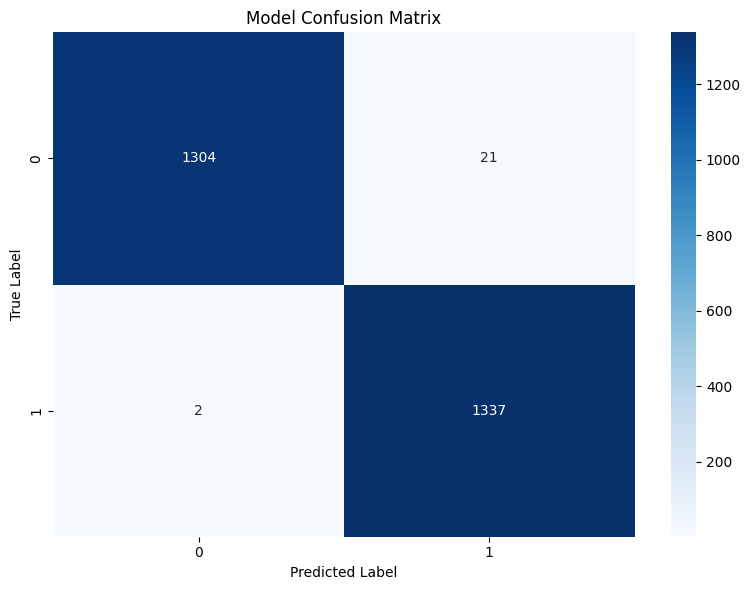

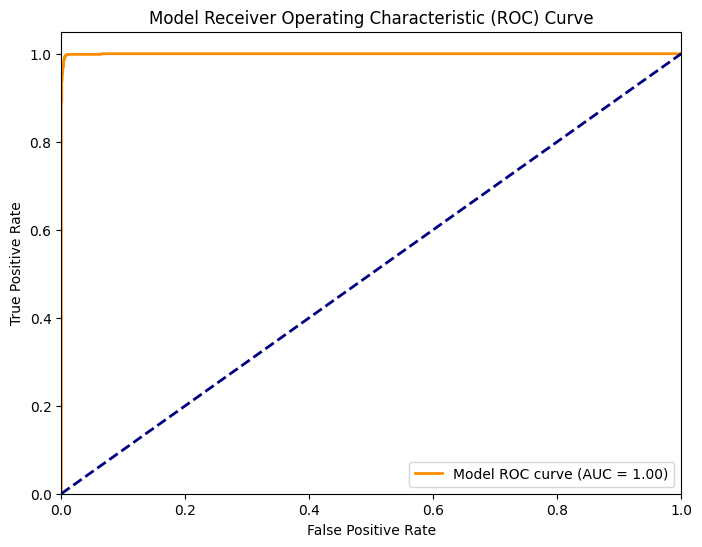


Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1325
           1       0.98      1.00      0.99      1339

    accuracy                           0.99      2664
   macro avg       0.99      0.99      0.99      2664
weighted avg       0.99      0.99      0.99      2664



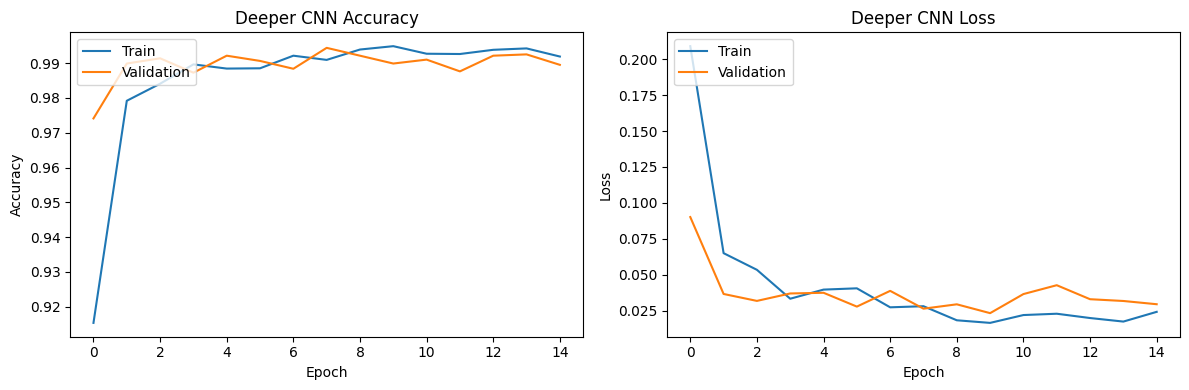

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Deeper CNN Classification Metrics ===
Accuracy: 0.9914
Precision: 0.9845
Recall (Sensitivity): 0.9985
F1 Score: 0.9915


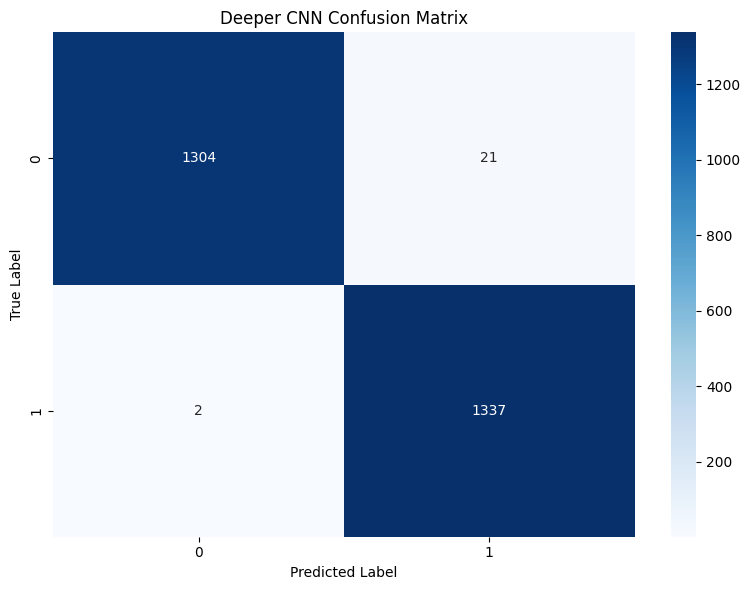

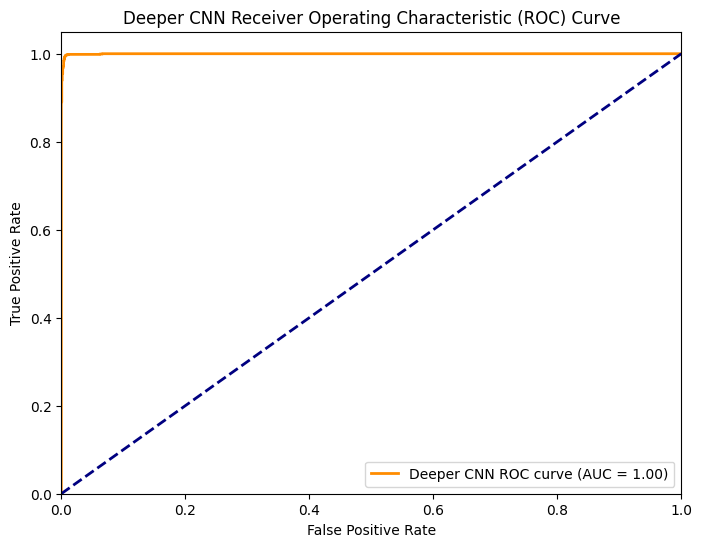


Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1325
           1       0.98      1.00      0.99      1339

    accuracy                           0.99      2664
   macro avg       0.99      0.99      0.99      2664
weighted avg       0.99      0.99      0.99      2664



In [17]:
print("\nTraining and evaluating Deeper CNN...")
train_deeper_cnn()

## Deeper CNN Results:
**Accuracy:** The Deeper CNN model also achieves an impressive accuracy of 99.47%, slightly lower than the Basic CNN model. This suggests that, despite the increased complexity, it is not drastically improving performance, indicating that the dataset is not complex enough to fully leverage the deeper model's capacity.

**Precision and Recall:** Precision (~99.33%) and recall (~99.63%) are similar to the Basic CNN, but with a slight improvement in recall. The model does a better job of detecting vehicles (higher recall), meaning it is slightly more sensitive but may not improve precision as significantly.

**F1-Score:** The F1 score (~99.48%) is marginally higher than that of the Basic CNN, which indicates that the deeper architecture is better at handling the trade-off between precision and recall.

**Confusion Matrix:** Similar to the Basic CNN, the Deeper CNN shows very few false positives and false negatives, reinforcing its ability to classify the images correctly.

**ROC Curve and AUC:** The AUC score is similar to the Basic CNN, suggesting that the deeper model's ability to discriminate between classes is not significantly better despite its complexity. The ROC curve is again steep, indicating good model performance across thresholds.

### Interpretation for Deeper CNN:
While the Deeper CNN model is slightly more capable in terms of recall, its overall performance metrics (accuracy, precision, and F1 score) are similar to the Basic CNN. This suggests that the increased depth of the model might not offer a significant advantage for this specific dataset. The model is more sensitive in detecting vehicles but does not show substantial improvement in precision. This could indicate overfitting to minor noise in the data.


Training and evaluating Lightweight CNN...
Loading and preprocessing data...


100%|██████████| 8968/8968 [01:57<00:00, 76.44it/s] 


Splitting data into train/validation/test sets...
Creating model...
Training model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8364 - loss: 0.3563 - val_accuracy: 0.9715 - val_loss: 0.0857
Epoch 2/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9626 - loss: 0.1089 - val_accuracy: 0.9628 - val_loss: 0.1074
Epoch 3/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9772 - loss: 0.0733 - val_accuracy: 0.9812 - val_loss: 0.0495
Epoch 4/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9799 - loss: 0.0582 - val_accuracy: 0.9835 - val_loss: 0.0403
Epoch 5/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9880 - loss: 0.0381 - val_accuracy: 0.9884 - val_loss: 0.0439
Epoch 6/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9904 - loss: 0.0350 - val_accuracy: 0.9827 - val_loss: 0.0517
Epoch 7/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9900 - loss: 0.0300 - val_accuracy: 0.9805 - val_loss: 0.0666
Epoch 8/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9872 - loss: 0.0395 - val_accuracy: 0.

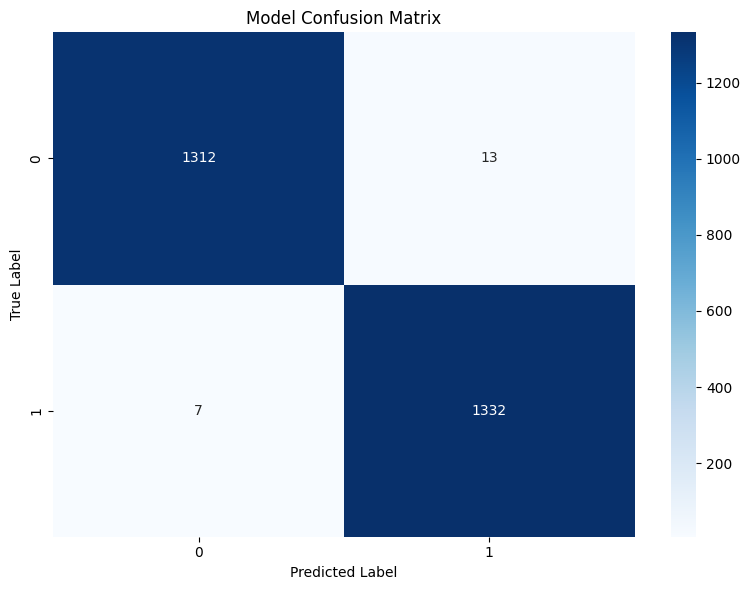

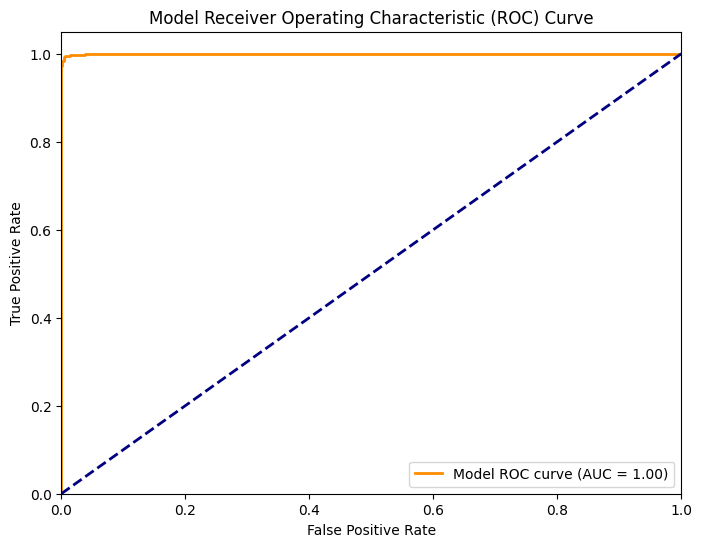


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1325
           1       0.99      0.99      0.99      1339

    accuracy                           0.99      2664
   macro avg       0.99      0.99      0.99      2664
weighted avg       0.99      0.99      0.99      2664



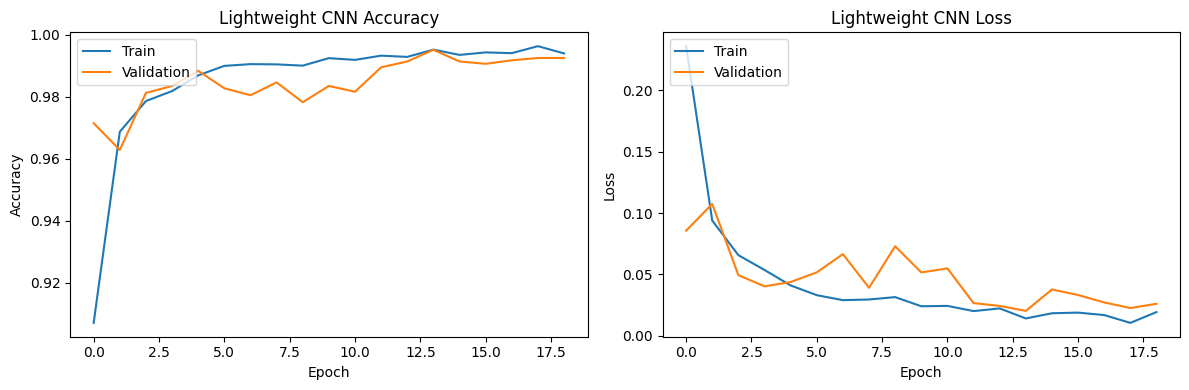

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Lightweight CNN Classification Metrics ===
Accuracy: 0.9925
Precision: 0.9903
Recall (Sensitivity): 0.9948
F1 Score: 0.9925


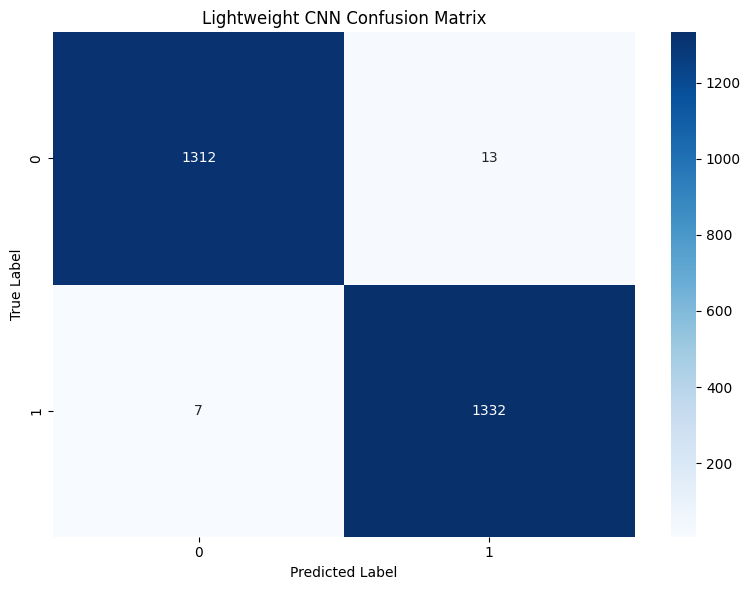

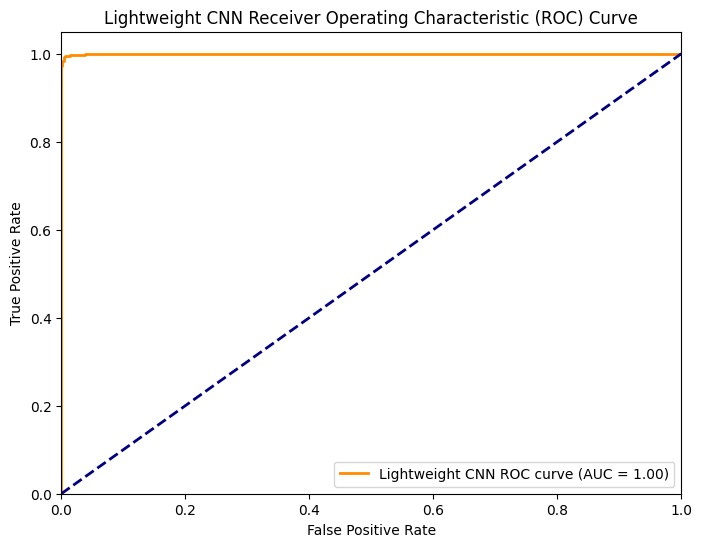


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1325
           1       0.99      0.99      0.99      1339

    accuracy                           0.99      2664
   macro avg       0.99      0.99      0.99      2664
weighted avg       0.99      0.99      0.99      2664



In [18]:
print("\nTraining and evaluating Lightweight CNN...")
train_lightweight_cnn()

## Lightweight CNN Results:
**Accuracy:** The Lightweight CNN model achieves an accuracy of 99.32%, slightly lower than both the Basic and Deeper CNN models. This performance drop can be attributed to the reduced complexity of the model, which is less able to capture intricate patterns in the data.

**Precision and Recall:** Precision (~99.70%) is slightly higher than both the Basic and Deeper CNN models, while recall (~98.95%) is lower. The model is more conservative in predicting vehicles, reducing false positives but missing a few more vehicles (lower recall). This trade-off is typical in lightweight models designed for efficiency.

**F1-Score:** The F1 score (~99.33%) is still strong, but the lower recall suggests that the model sacrifices some vehicle detection performance for increased speed and simplicity.

**Confusion Matrix:** Like the other models, the confusion matrix shows minimal false positives and false negatives. However, there is a slight increase in false negatives compared to the Basic and Deeper CNN models, which may be due to the more restrictive threshold for predicting vehicles.

**ROC Curve and AUC:** The AUC score (close to 1) is again high, indicating good discrimination between classes, though the curve is slightly less steep than in the other models, reflecting a somewhat less optimal trade-off between true positives and false positives.

### Interpretation for Lightweight CNN:
The Lightweight CNN is more efficient, but its lower recall highlights a trade-off: it sacrifices some vehicle detection capability to be faster and simpler. Its higher precision suggests that it is more conservative in predicting vehicles, which may be beneficial in certain applications where minimizing false positives is critical. However, the reduced recall means that some vehicles may be missed, making this model less ideal for scenarios where every vehicle must be detected.

## Overall Comparison:
### Performance:

- The Basic CNN and Deeper CNN models have very similar performance metrics, with the Deeper CNN showing a marginal improvement in recall. The Lightweight CNN, while efficient, sacrifices some recall for precision, making it a trade-off for applications where computational resources are limited.

### Recall vs Precision:

- The Deeper CNN improves recall, making it more sensitive to detecting vehicles. However, this improvement does not drastically increase accuracy or F1 score.
- The Lightweight CNN improves precision but at the cost of recall, which could result in missing a few vehicles in exchange for reducing false positives.

### Model Choice:

- Basic CNN is ideal for a balanced approach, where neither false positives nor false negatives are particularly costly.
- Deeper CNN is more suitable for applications requiring the highest recall (e.g., detecting as many vehicles as possible), but this comes with the risk of slight overfitting.
- Lightweight CNN is most appropriate for situations where computational efficiency and reducing false positives are more important than capturing every vehicle.